Training the best HMM prediction model from scratch

In [3]:
# add modules to path
import sys
sys.path.insert(1, '../src')

# library imports
import torch
import torch.nn as nn
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

import torch.nn.functional as F
from torch.distributions.normal import Normal

# project imports
import data_processing as dp
import train_eval as te
import models_nn as mnn

# autoreload all modules
%load_ext autoreload
%autoreload 2


In [4]:
RNG_SEED = 42

np.random.seed(RNG_SEED)

# Load the data from the .npz file
data_dict_ppmi, pd_keys, control_keys = dp.load_ppmi_data()
data_dict_hcp = dp.load_hcp_data()
hcp_keys = list(data_dict_hcp.keys())

# Train-test split
# (We don't need validation set for this task)
test_size = 0.3
train_size = 1 - test_size

# Shuffle indices
np.random.shuffle(pd_keys)
np.random.shuffle(control_keys)
np.random.shuffle(hcp_keys)

# Split indices
train_pd = pd_keys[:int(train_size * len(pd_keys))]
test_pd = pd_keys[int(train_size * len(pd_keys)):]
train_control = control_keys[:int(train_size * len(control_keys))]
test_control = control_keys[int(train_size * len(control_keys)):]
train_hcp = hcp_keys[:int(train_size * len(hcp_keys))]
test_hcp = hcp_keys[int(train_size * len(hcp_keys)):]

# Combine into final splits and shuffle
train_keys = train_pd + train_control + train_hcp
test_keys = test_pd + test_control + test_hcp

# Create target arrays
y_train = np.concatenate([np.ones(len(train_pd)), np.zeros(len(train_control)), np.zeros(len(train_hcp))])
y_test = np.concatenate([np.ones(len(test_pd)), np.zeros(len(test_control)), np.zeros(len(test_hcp))])

# Shuffle the keys for each split
train_idx = np.arange(len(train_keys))
test_idx = np.arange(len(test_keys))
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

# Create final splits
train_keys = [train_keys[i] for i in train_idx]
test_keys = [test_keys[i] for i in test_idx]
y_train = y_train[train_idx].astype(int)
y_test = y_test[test_idx].astype(int)


Loaded 320/364 PD subjects and 44/364 Control subjects
Loaded 1445 subject-run combinations


In [7]:
def get_long_data(keys):
    """
    Extracts and normalizes framewise displacement and RMSD data for given keys.
    Prepares the data for input into hmmlearn models.
    Args:
        keys (list): List of keys to extract data for.
    Returns:
        X (np.ndarray): Concatenated and normalized feature matrix, shape (N, 2),
        lengths (list): List of lengths of each sequence corresponding to the keys.
    """

    X = []
    for k in keys:
        if k in data_dict_ppmi:
            a1, a2 = data_dict_ppmi[k]['framewise_displacement'][1:], data_dict_ppmi[k]['rmsd'][1:]
        elif k in data_dict_hcp:
            a1, a2 = data_dict_hcp[k]['framewise_displacement_equivalent'], data_dict_hcp[k]['relative_rms'][1:]
        else:
            raise ValueError(f"Key {k} not found in either dataset")
        a1 = (a1 - np.mean(a1)) / (np.std(a1) + 1e-8)
        a2 = (a2 - np.mean(a2)) / (np.std(a2) + 1e-8)
        x = np.vstack([a1, a2]).T
        X.append(x)
    lengths = [len(x) for x in X]
    X = np.concatenate(X, axis=0)
    
    return X, lengths


In [ ]:
X_train, lengths_train = get_long_data(train_keys)
X_test, lengths_test = get_long_data(test_keys)
X_train.shape, X_test.shape


((548818, 2), (237157, 2))

In [ ]:
from hmmlearn.hmm import GaussianHMM

# Create and fit the HMM model
# This was selected as the best model through cross-validation (see `modeling_stats.ipynb`).
model = GaussianHMM(n_components=5, covariance_type='full', n_iter=100, random_state=210, verbose=True)
model.fit(X_train, lengths=lengths_train)


         1 -1785686.42859307             +nan
         2 -1320030.36402956 +465656.06456351
         3 -1277683.04007945  +42347.32395011
         4 -1249042.93241600  +28640.10766346
         5 -1229480.43672669  +19562.49568931
         6 -1217161.92764954  +12318.50907715
         7 -1209622.68595003   +7539.24169951
         8 -1204702.13141264   +4920.55453740
         9 -1201249.54999877   +3452.58141386
        10 -1198692.68195713   +2556.86804164
        11 -1196706.33845847   +1986.34349866
        12 -1195123.37208756   +1582.96637091
        13 -1193832.30124518   +1291.07084238
        14 -1192731.20355081   +1101.09769437
        15 -1191742.20198630    +989.00156451
        16 -1190807.63272307    +934.56926323
        17 -1189880.40795901    +927.22476406
        18 -1188917.73557712    +962.67238190
        19 -1187878.79377291   +1038.94180420
        20 -1186727.44594652   +1151.34782640
        21 -1185440.50938808   +1286.93655844
        22 -1184014.26008116   +14

GaussianHMM(covariance_type='full', n_components=5, n_iter=100,
            random_state=210, verbose=True)

In [11]:
def compute_state_proportions(model, X, lengths):
    """
    Given a fitted HMM model, data X, and sequence lengths,
    returns an array of shape (n_samples, n_states) where each row
    contains the proportion of time spent in each state for a sample.
    """
    states = model.predict(X, lengths=lengths)
    n_states = model.n_components
    n_samples = len(lengths)
    proportions = np.zeros((n_samples, n_states))
    seq_starts = np.cumsum([0] + list(lengths[:-1]))
    seq_ends = np.cumsum(lengths)
    for i, (st, en) in enumerate(zip(seq_starts, seq_ends)):
        sample_states = states[st:en]
        for s in range(n_states):
            proportions[i, s] = np.mean(sample_states == s)
    return proportions


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

proportions = compute_state_proportions(model, X_train, lengths_train)
prop_state4 = proportions[:, 4]  # Proportion in state 4

# Train a logistic regression model to predict group membership
C_grid = np.logspace(-10, 5, 50)  # Regularization strength grid

# Perform grid search to find the best regularization strength
# (High variance so not that reliable)
log_reg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=RNG_SEED),
    param_grid={'C': C_grid},
    scoring='f1_macro',  # Use F1 score for evaluation
    cv=5,
    verbose=1
)

log_reg.fit(prop_state4.reshape(-1, 1), y_train)
# Best regularization strength
best_C = log_reg.best_params_['C']
print(f"Best regularization strength: {best_C}")
print(f"Best F1 score: {log_reg.best_score_:.4f}")
log_reg_best = log_reg.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best regularization strength: 0.30888435964774846
Best F1 score: 0.9376


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

def predict_probs(hmm, log_reg, X, lengths):
    """
    Predicts logits for each sample in X using the fitted HMM model.
    Returns a tensor of shape (n_samples,) where each row contains the logits
    """
    proportions = compute_state_proportions(hmm, X, lengths)
    prop_state4 = proportions[:, 4]  # Proportion in state 1
    return log_reg.predict_proba(prop_state4.reshape(-1, 1))[:, 1]  # Probability of being in PD group

def evaluate_model(hmm, log_reg, X, lengths, y_true,
                   threshold=0.5, print_report=True):
    """
    Evaluates the model on the given data.
    Returns accuracy, F1 score, confusion matrix, and classification report.
    """
    y_pred_probs = predict_probs(hmm, log_reg, X, lengths)
    y_pred = (y_pred_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    if print_report:
        print(f"AUC Score: {roc_auc_score(y_true, y_pred_probs):.4f}")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix:")
        print(cm)

    return y_pred_probs, accuracy, f1, cm


In [ ]:
# Training set evaluation
print("Evaluating on training set:")
y_pred_probs_train = evaluate_model(
    model, log_reg_best, X_train, lengths_train, y_train
)[0]

print('-' * 60)

# Test set evaluation
print("Evaluating on test set:")
y_pred_probs = evaluate_model(
    model, log_reg_best, X_test, lengths_test, y_test
)[0]


Evaluating on training set:
AUC Score: 0.9822
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1041
           1       0.82      0.99      0.90       224

    accuracy                           0.96      1265
   macro avg       0.91      0.97      0.94      1265
weighted avg       0.97      0.96      0.96      1265

Confusion Matrix:
[[993  48]
 [  2 222]]
------------------------------------------------------------
Evaluating on test set:
AUC Score: 0.9797
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       448
           1       0.83      1.00      0.91        96

    accuracy                           0.96       544
   macro avg       0.91      0.98      0.94       544
weighted avg       0.97      0.96      0.96       544

Confusion Matrix:
[[428  20]
 [  0  96]]


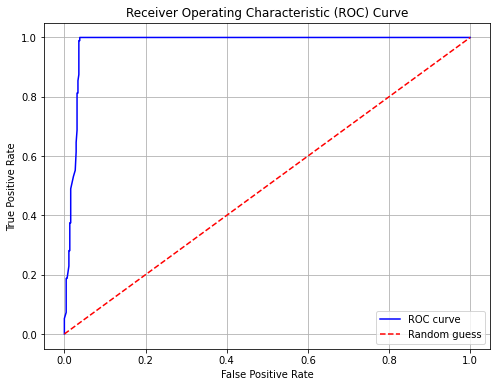

In [ ]:
# Plot ROC curve
import matplotlib.pyplot as plt
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()
# Plot ROC curve for test set
plot_roc_curve(y_test, y_pred_probs)


In [ ]:
y_pred = (y_pred_probs >= 0.5).astype(int)
misclassified_keys = [k for i, k in enumerate(test_keys) if y_pred[i] != y_test[i]]

# Compute proportion in PPMI vs HCP
misclassified_keys_ppmi = [k for k in misclassified_keys if k in data_dict_ppmi]
print(f"Proportion of misclassified keys in PPMI: {len(misclassified_keys_ppmi) / len(misclassified_keys):.2f}")
print(f"Proportion of overall keys in PPMI: {len(data_dict_ppmi) / (len(data_dict_ppmi) + len(data_dict_hcp)):.2f}")


Proportion of misclassified keys in PPMI: 0.70
Proportion of overall keys in PPMI: 0.32


In [ ]:
misclassified_keys


['sub-167746_run-01',
 'sub-101195_run-01',
 'sub-149716_run-02',
 'HCA7046968_run-01',
 'HCA7410559_run-01',
 'sub-115698_run-01',
 'sub-178413_run-01',
 'sub-100890_run-01',
 'HCA6686191_run-02',
 'sub-153233_run-02',
 'HCA9894012_run-02',
 'sub-292982_run-01',
 'sub-156484_run-01',
 'sub-120545_run-01',
 'sub-138022_run-02',
 'sub-128335_run-01',
 'sub-130028_run-02',
 'HCA6678495_run-02',
 'sub-4032_run-01',
 'HCA9202057_run-02']